In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd
import statsmodels.api as sm

import bars
import c
import labels
import signals
import u

# Data Generation

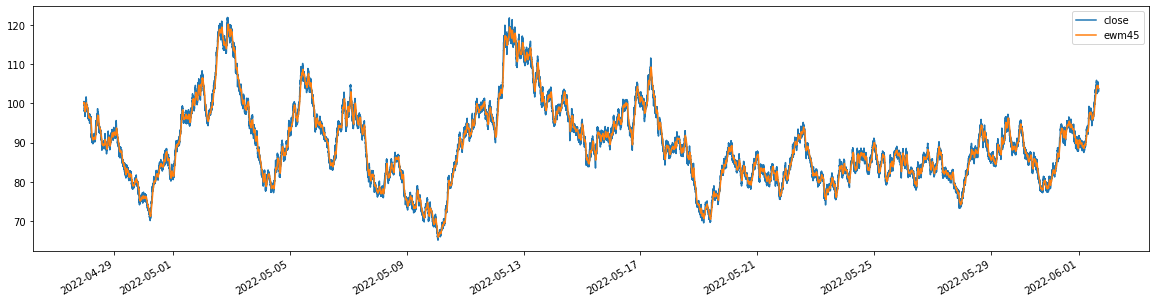

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, var=0.00001, n_samples=50000)
data["ewm45"] = data["close"].ewm(span=45).mean()
data["close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

# Finding Events and Barriers

In [4]:
ewm45 = data["ewm45"]
curr = data["close"]
prev = data["close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
data["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
data["trade"] = cross_up | cross_down
data.head()

,close,ewm45,dir,trade
2022-04-27 22:56:21.811921,100.00,100.000000,0,False
2022-04-27 22:57:21.811921,100.51,100.260667,1,True
2022-04-27 22:58:21.811921,100.26,100.260434,-1,True
2022-04-27 22:59:21.811921,99.95,100.177577,-1,True
2022-04-27 23:00:21.811921,100.20,100.182469,1,True


In [5]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std())
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(1, "h")

In [6]:
indices = data.loc[data["trade"]].index
barriers = signals.get_price_target_stop_loss_indices(
    data,
    indices,
    target=target,
    side=data.loc[indices, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt
2022-04-27 22:57:21.811921,NaT,2022-04-27 23:24:21.811921,1,0 days 01:00:00,-1,False
2022-04-27 22:58:21.811921,2022-04-27 23:41:21.811921,NaT,-1,0 days 01:00:00,1,True
2022-04-27 22:59:21.811921,2022-04-27 23:42:21.811921,NaT,-1,0 days 01:00:00,1,True
2022-04-27 23:00:21.811921,NaT,2022-04-27 23:41:21.811921,1,0 days 01:00:00,-1,False
2022-04-27 23:01:21.811921,2022-04-27 23:47:21.811921,NaT,-1,0 days 01:00:00,1,True


# Concurrent Labels

In [7]:
counts = labels.get_concurrent_label_count(data, barriers)
counts.name = "counts"
counts.head()

2022-04-27 22:56:21.811921    0
2022-04-27 22:57:21.811921    1
2022-04-27 22:58:21.811921    2
2022-04-27 22:59:21.811921    3
2022-04-27 23:00:21.811921    4
Freq: T, Name: counts, dtype: int64

# Uniqueness

<AxesSubplot:>

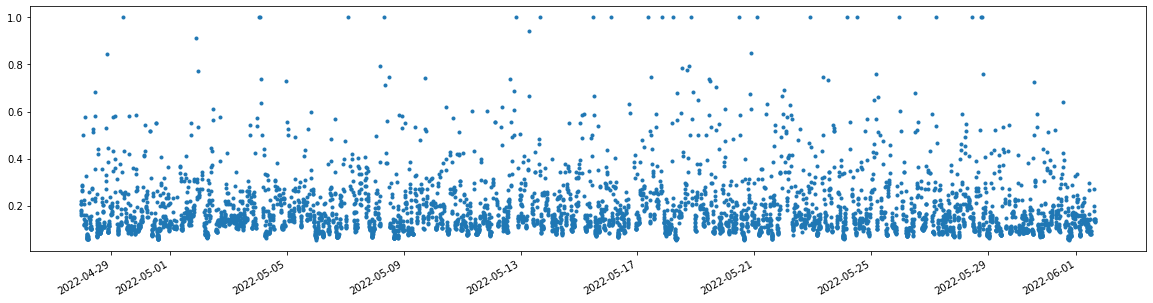

In [8]:
uniqueness = labels.get_label_uniqueness(barriers, counts)
uniqueness.plot(style=".")

<AxesSubplot:>

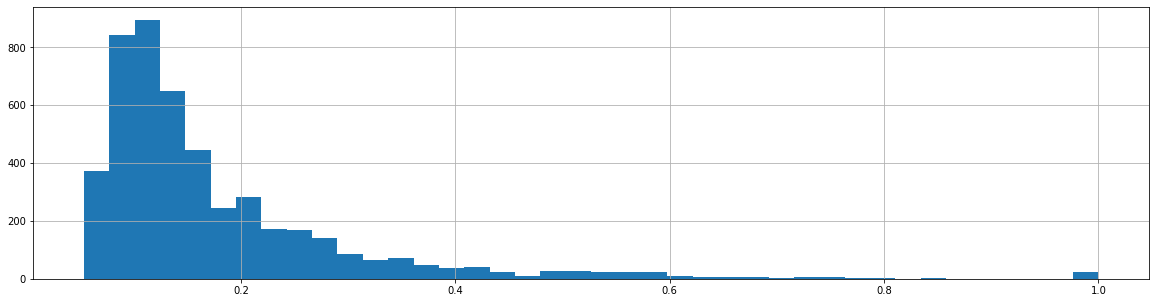

In [9]:
uniqueness.hist(bins=40)

# Test Autocorrelation Of Counts Using NB GLM

In [10]:
response = counts[1:]
predictor = sm.add_constant(counts[:-1])
model = sm.NegativeBinomial(response, predictor.to_numpy()).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.848939
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                 counts   No. Observations:                49999
Model:               NegativeBinomial   Df Residuals:                    49997
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Jun 2022   Pseudo R-squ.:                  0.2857
Time:                        16:15:36   Log-Likelihood:                -92445.
converged:                       True   LL-Null:                   -1.2942e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2856      0.005     53.171      0.000       0.275       0.296
x1             0.1884      0.001    283.983      0.000       0.187       0.190
alpha          0.0221      0.001     20.410      0.000       0.020       0.024
==============================================================================
"""

# Test Autocorrelation of Uniqueness Using Binomial GLM 

In [11]:
response = uniqueness[1:]
predictor = sm.add_constant(uniqueness[:-1])
model = sm.GLM(response, predictor.to_numpy(), family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4792
Model:                            GLM   Df Residuals:                     4790
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1544.8
Date:                Wed, 01 Jun 2022   Deviance:                       284.29
Time:                        16:15:36   Pearson chi2:                     336.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03493
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1860      0.066    -33.340      0.000      -2.315      -2.058
x1             3.3651      0.260     12.963      0.000       2.856       3.874
==============================================================================
"""